# Geo

1. Plot sample distribution on world map.

---
## Setup

### Import Modules

In [1]:
import geopandas
import matplotlib.pyplot as plt
import os
import shapely

### File Paths

In [2]:
metadata_path = "../../docs/results/latest/metadata/metadata.tsv"
outdir = "../../docs/results/latest/geo"

# Create output directory if it doesn't exist
if not os.path.exists(outdir):
    os.mkdir(outdir)

### Variables

In [3]:
from config import *

GEO_ATTR = "Province"
CRS="epsg:4326"
WEB_MERCATOR_CRS = "epsg:3857"

SCRIPT_NAME = "geo"

### Import Dataframe as Pandas

In [4]:
metadata_df = pd.read_csv(metadata_path, sep='\t')
# Fix the problem with multiple forms of NA in the table
# Consolidate missing data to the NO_DATA_CHAR
metadata_df.fillna(NO_DATA_CHAR, inplace=True)
metadata_df.set_index("Sample", inplace=True)

### Convert Dataframe to GeoPandas

In [5]:
# Remove NO DATA Cells
# RETHINK THIS WHEN INTERNAL NODES HAVE DATA!!
df = metadata_df[metadata_df[GEO_ATTR + "Lon"] != NO_DATA_CHAR]
geometry = [shapely.geometry.Point(xy) for xy in zip(df[GEO_ATTR + "Lon"], df[GEO_ATTR + "Lat"])]
df = df.drop([GEO_ATTR + "Lon", GEO_ATTR + "Lat"], axis=1)
#WGS84 = "epsg:4326"
gdf_points = geopandas.GeoDataFrame(df, crs=CRS, geometry=geometry)

gdf_points

,Strain,Date,DateBP,Country,Province,CountryLat,CountryLon,Biovar,Branch_Major,Branch_Minor,BioSample,BioSampleComment,geometry
Sample,,,,,,,,,,,,,
GCA_009669545.1_ASM966954v1_genomic,42126,2006,-15,China,Xinjiang,35.0001,105,Antiqua,0.ANT,0.ANT1,SAMN07722925,KEEP: Assembly Modern,POINT (85.46335 42.48050)
GCA_009669555.1_ASM966955v1_genomic,42123,2005,-16,China,Xinjiang,35.0001,105,Antiqua,0.ANT,0.ANT1,SAMN07722924,KEEP: Assembly Modern,POINT (85.46335 42.48050)
GCA_009669565.1_ASM966956v1_genomic,42118,2005,-16,China,Xinjiang,35.0001,105,Antiqua,0.ANT,0.ANT1,SAMN07722923,KEEP: Assembly Modern,POINT (85.46335 42.48050)
GCA_009669605.1_ASM966960v1_genomic,42117,2005,-16,China,Xinjiang,35.0001,105,Antiqua,0.ANT,0.ANT1,SAMN07722922,KEEP: Assembly Modern,POINT (85.46335 42.48050)
GCA_009669625.1_ASM966962v1_genomic,42116,2005,-16,China,Xinjiang,35.0001,105,Antiqua,0.ANT,0.ANT1,SAMN07722921,KEEP: Assembly Modern,POINT (85.46335 42.48050)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
SAMEA3713711,OBS107,[1720:1722],[-301:-299],France,Provence-Alpes-Côte d'Azur,46.6034,1.88833,Second Pandemic,Second Pandemic,Second Pandemic,SAMEA3713711,KEEP: SRA Ancient,POINT (6.06385 44.05806)
SAMN00715800,8291,[1348:1350],[-673:-671],England,Greater London,52.531,-1.26491,Second Pandemic,Second Pandemic,Second Pandemic,SAMN00715800,KEEP: SRA Ancient,POINT (-0.14406 51.48933)
SAMEA3541827,RISE509,[-2876:-2677],[-4897:-4698],Russia,Krasnoyarsk Krai,64.6863,97.7453,Bronze Age Plague,Bronze Age,Bronze Age,SAMEA3541827,KEEP: SRA Ancient,POINT (97.09800 63.32338)


### Prep Plot Data

In [21]:
# --------------------------------------
# World Basemap
world_polygons = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# --------------------------------------
# Keller et al. 2019
gdf_keller = gdf_points[(gdf_points["BioSampleComment"].str.contains("Keller 2019")) & (gdf_points["BioSampleComment"].str.contains("Modern"))]


# Get count of each location
gdf_keller_count = {}
for geo in gdf_keller[GEO_ATTR]:
    if geo not in gdf_keller_count:
        gdf_keller_count[geo] = 0
    gdf_keller_count[geo] += 1

# Drop duplicate entries
gdf_keller = gdf_keller.drop_duplicates(subset = 'Province', keep = 'first')

# Store as list for plotting
gdf_keller_size = []
for geo in gdf_keller[GEO_ATTR]:
    gdf_keller_size.append(gdf_keller_count[geo])

# --------------------------------------
# This study
gdf_this_study = gdf_points[(gdf_points["BioSampleComment"].str.contains("Keller 2019")  == False ) & (gdf_points["BioSampleComment"].str.contains("Modern"))]
# Get count of each location
gdf_this_study_count = {}
for geo in gdf_this_study[GEO_ATTR]:
    if geo not in gdf_this_study_count:
        gdf_this_study_count[geo] = 0
    gdf_this_study_count[geo] += 1

    # Drop duplicate entries
gdf_this_study = gdf_this_study.drop_duplicates(subset = 'Province', keep = 'first')


# Store as list for plotting
gdf_this_study_size = []
for geo in gdf_this_study[GEO_ATTR]:
    gdf_this_study_size.append(gdf_this_study_count[geo])


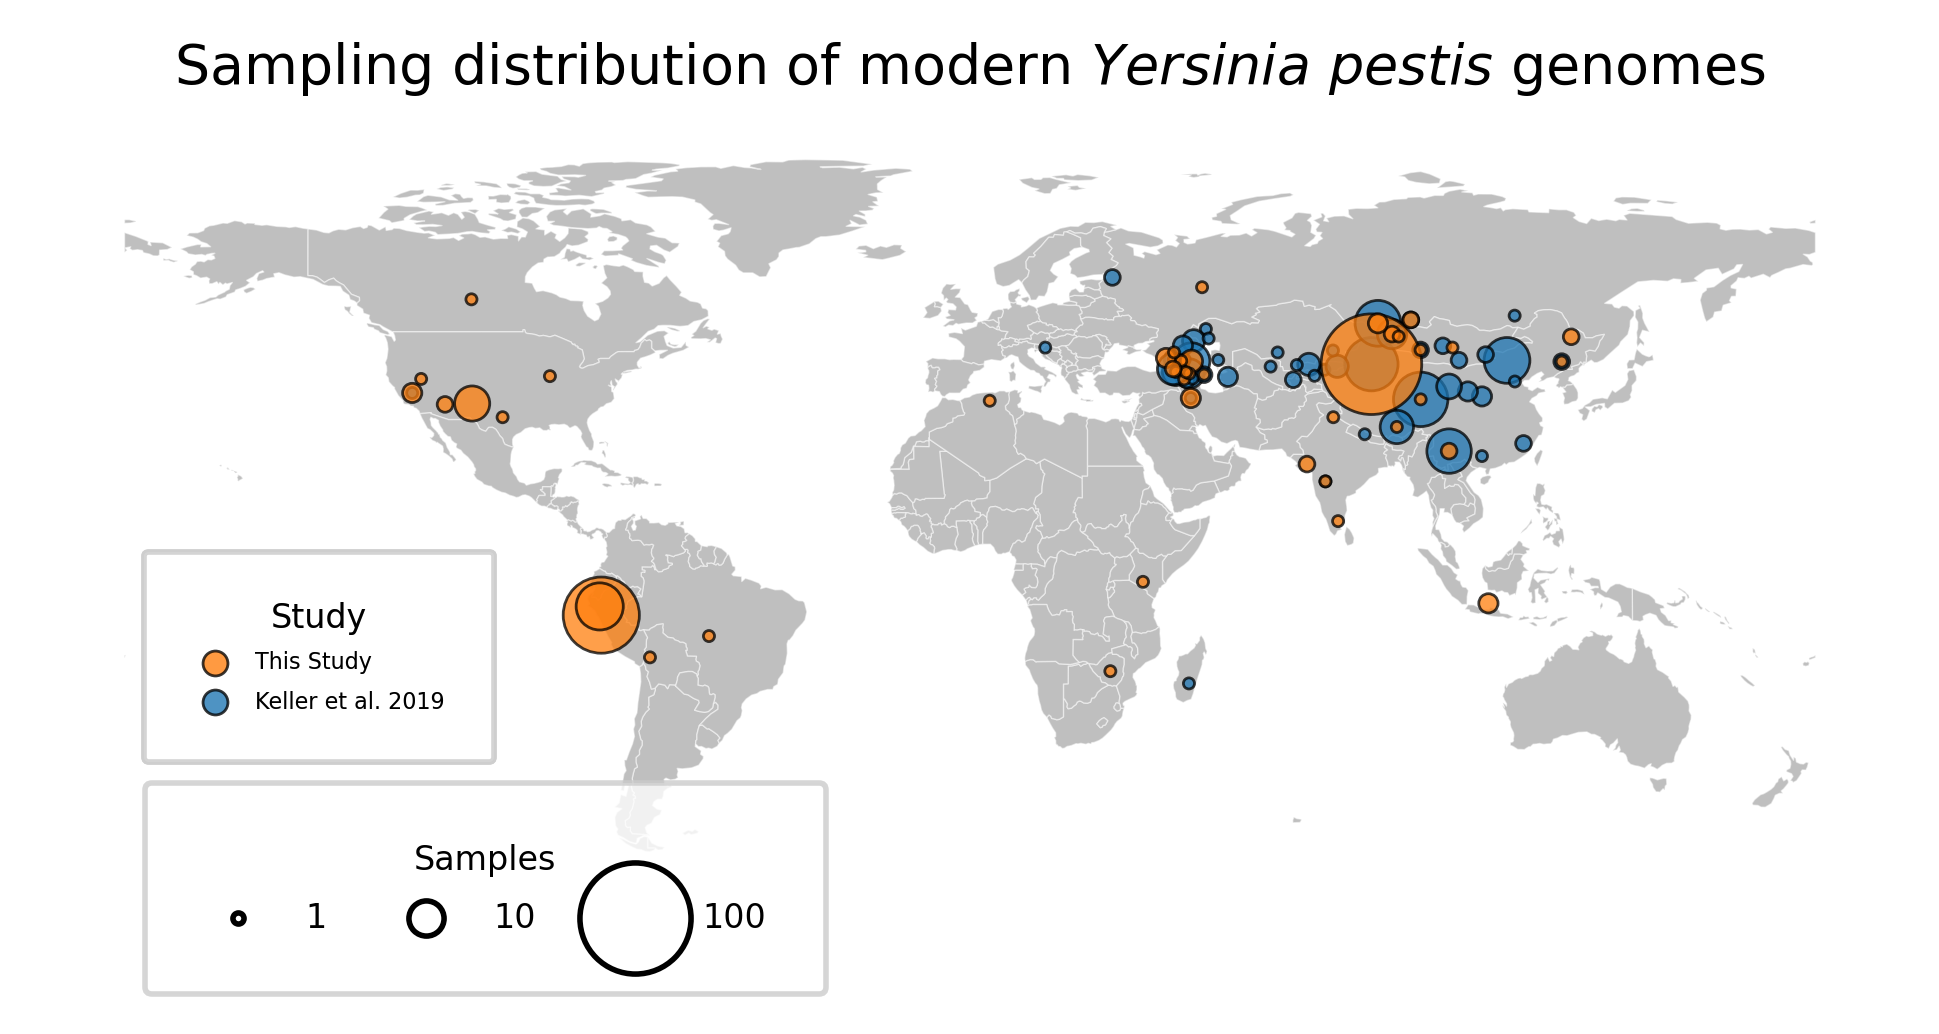

In [28]:
fig, ax1 = plt.subplots(1, dpi=dpi)

# Make everything appear larger
marker_scale = 4

# --------------------------------------
# World Basemap
world_polygons.plot(ax=ax1, 
                    zorder=1, 
                    alpha=0.5, 
                    color="grey",
                    edgecolor="white", 
                    linewidth=0.25,
                   )



# --------------------------------------
# This study
gdf_this_study.plot(ax=ax1, 
                zorder=4, 
                markersize=[s*marker_scale for s in gdf_this_study_size], 
                color=DISC_CMAPLIST[1],
                edgecolor="black",
                linewidths=0.5,
                label="This Study",
                legend=True,
                alpha=0.75,
                )

# --------------------------------------
# Keller et al. 2019
gdf_keller.plot(ax=ax1, 
                zorder=3, 
                markersize=[s*marker_scale for s in gdf_keller_size], 
                color=DISC_CMAPLIST[0],
                edgecolor="black",
                linewidths=0.5,
                label="Keller et al. 2019",
                legend=True,
                alpha=0.75,
                )

# --------------------------------------
# Limits

# Sorry Antarctica
ax1.set_ylim(-63,)

# --------------------------------------
# Labels
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.set_title("Sampling distribution of modern " 
          + "$\it Yersinia$" 
          + " " 
          + "$\it pestis$"
          + " " 
          + "genomes")
ax1.axis('off')
# --------------------------------------
# Legend
legend = plt.legend(frameon=True, markerscale=None)
for handle in legend.legendHandles:
    handle.set_sizes([20])
    
size_l1  = plt.scatter([],[], s=1 * marker_scale, edgecolors='black', color="white")
size_l10 = plt.scatter([],[], s=10 * marker_scale, edgecolors='black', color="white")
size_l100 = plt.scatter([],[], s=100 * marker_scale, edgecolors='black', color="white")

size_labels = ["1", "10", "100"]

size_legend = plt.legend([size_l1, size_l10, size_l100], 
                 size_labels,
                 loc="center left", 
                 bbox_to_anchor=(0.0475, 0),
                 ncol=3,
                 borderpad = 1.8, 
                 title="Samples", 
                 title_fontsize=6,
                 fontsize=6, 
                 frameon=True,
                 #labelspacing=2,
                 handletextpad=1,
                )

color_legend = ax1.legend(loc="center left",
                          bbox_to_anchor=(0.05, 0.3),
                          ncol=1,
                          borderpad = 2.2, 
                          title="Study", 
                          title_fontsize=6,
                          fontsize=4, 
                          frameon=True,
                         )

for handle in color_legend.legendHandles:
    handle.set_sizes([20])
    
# Add multiple legends as artists
ax1.add_artist(color_legend)
ax1.add_artist(size_legend)


# --------------------------------------------
# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_global_study." + FMT)
plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")

In [15]:
gdf_keller.drop_duplicates(subset = 'Province', keep = 'first')

,Strain,Date,DateBP,Country,Province,CountryLat,CountryLon,Biovar,Branch_Major,Branch_Minor,BioSample,BioSampleComment,geometry
Sample,,,,,,,,,,,,,
GCA_000734805.1_ASM73480v1_genomic,231,1947,-74,Kyrgyzstan,Naryn Region,41.5089,74.7241,Antiqua,0.ANT,0.ANT3,SAMN02777961,KEEP: Assembly Modern Kutyrev 2018 Keller 2019,POINT (75.45197 41.35647)
GCA_000169655.1_ASM16965v1_genomic,K1973002,1973,-48,China,Xinjiang,35.0001,105,Medievalis,2.MED,2.MED2,SAMN02404402,KEEP: Assembly Modern Morelli 2010 Keller 2019,POINT (85.46335 42.48050)
GCA_000170275.1_ASM17027v1_genomic,F1991016,1991,-30,China,Yunnan,35.0001,105,Orientalis,1.ORI,1.ORI2,SAMN02404399,KEEP: Assembly Modern Morelli 2010 Cui 2013 Ke...,POINT (102.00000 25.00000)
GCA_000168235.2_ASM16823v2_genomic,IP275,1995,-26,Madagascar,Province de Fianarantsoa,-18.925,46.4416,Orientalis,1.ORI,1.ORI3,SAMN02404398,KEEP: Assembly Modern Morelli 2010 Cui 2013 Ke...,POINT (46.61457 -21.74325)
GCA_000182505.1_ASM18250v1_genomic,India195,[1898:1950],[-123:-71],India,Maharashtra,22.3511,78.6677,Orientalis,1.ORI,1.ORI1,SAMN02403942,KEEP: Assembly Modern Cui 2013 Keller 2019,POINT (75.67416 18.90684)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCA_000324965.1_ASM32496v1_genomic,H1959004,1959,-62,China,Jilin,35.0001,105,Antiqua,2.ANT,2.ANT3,SAMN02403082,KEEP: Assembly Modern Cui 2013 Keller 2019,POINT (125.98161 42.99950)
GCA_000324905.1_ASM32490v1_genomic,G1996010,1996,-25,China,Tibet,35.0001,105,Antiqua,2.ANT,2.ANT2,SAMN02403079,KEEP: Assembly Modern Cui 2013 Keller 2019,POINT (90.87498 29.85564)
GCA_000324825.1_ASM32482v1_genomic,F1946001,1946,-75,China,Fujian,35.0001,105,Orientalis,1.ORI,1.ORI1,SAMN02403075,KEEP: Assembly Modern Cui 2013 Keller 2019,POINT (117.84278 26.54500)
